<a href="https://colab.research.google.com/github/maheshyonjan/BookListUpdated/blob/master/Big_Data_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import to_timestamp,try_to_timestamp
from pyspark.sql.functions import when, col, trim ,coalesce, avg, expr
from pyspark.sql.types import StringType,TimestampType
import pandas as pd # Import pandas
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:

# Create Spark session
spark = SparkSession.builder \
    .appName("LFB Mobilisation EDA") \
    .config("spark.python.worker.reuse", "true") \
    .config("spark.python.worker.timeout", "300") \
    .getOrCreate()

In [37]:
lfb_files = [
    'LFB Mobilisation data from January 2009 - 2014.csv',
    'LFB Mobilisation data from 2015 - 2020.csv',
    'LFB Mobilisation data from 2021 - 2024.csv',
    'LFB Mobilisation data 2025 onwards.csv'
]

# Read the first file
df = spark.read.csv(lfb_files[0], header=True, inferSchema=True)

# Union with remaining files, allowing missing columns
for file in lfb_files[1:]:
    next_df = spark.read.csv(file, header=True, inferSchema=True)
    df = df.unionByName(next_df, allowMissingColumns=True)


def clean_null_strings(df):
    # Find all string columns
    string_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]

    null_values = ["NULL", "null", "", "NaN", "nan", "N/A", "n/a"]

    for c in string_cols:
        df = df.withColumn(
            c,
            when(col(c).isin(null_values), None).otherwise(col(c))
        )
    return df

#Clean null strings
df = clean_null_strings(df)

In [38]:
df.printSchema()
df.show(5)
df.count()

root
 |-- IncidentNumber: string (nullable = true)
 |-- CalYear: integer (nullable = true)
 |-- HourOfCall: integer (nullable = true)
 |-- ResourceMobilisationId: integer (nullable = true)
 |-- Resource_Code: string (nullable = true)
 |-- PerformanceReporting: string (nullable = true)
 |-- DateAndTimeMobilised: string (nullable = true)
 |-- DateAndTimeMobile: string (nullable = true)
 |-- DateAndTimeArrived: string (nullable = true)
 |-- TurnoutTimeSeconds: string (nullable = true)
 |-- TravelTimeSeconds: string (nullable = true)
 |-- AttendanceTimeSeconds: integer (nullable = true)
 |-- DateAndTimeLeft: string (nullable = true)
 |-- DateAndTimeReturned: string (nullable = true)
 |-- DeployedFromStation_Code: string (nullable = true)
 |-- DeployedFromStation_Name: string (nullable = true)
 |-- DeployedFromLocation: string (nullable = true)
 |-- PumpOrder: integer (nullable = true)
 |-- PlusCode_Code: string (nullable = true)
 |-- PlusCode_Description: string (nullable = true)
 |-- Dela

2595663

In [39]:
def convert_time_data(df: DataFrame) -> DataFrame:
    # Cast time fields to integer
    df = df.withColumn("TurnoutTimeSeconds", col("TurnoutTimeSeconds").cast("int"))
    df = df.withColumn("TravelTimeSeconds", col("TravelTimeSeconds").cast("int"))

    return df

df = convert_time_data(df)


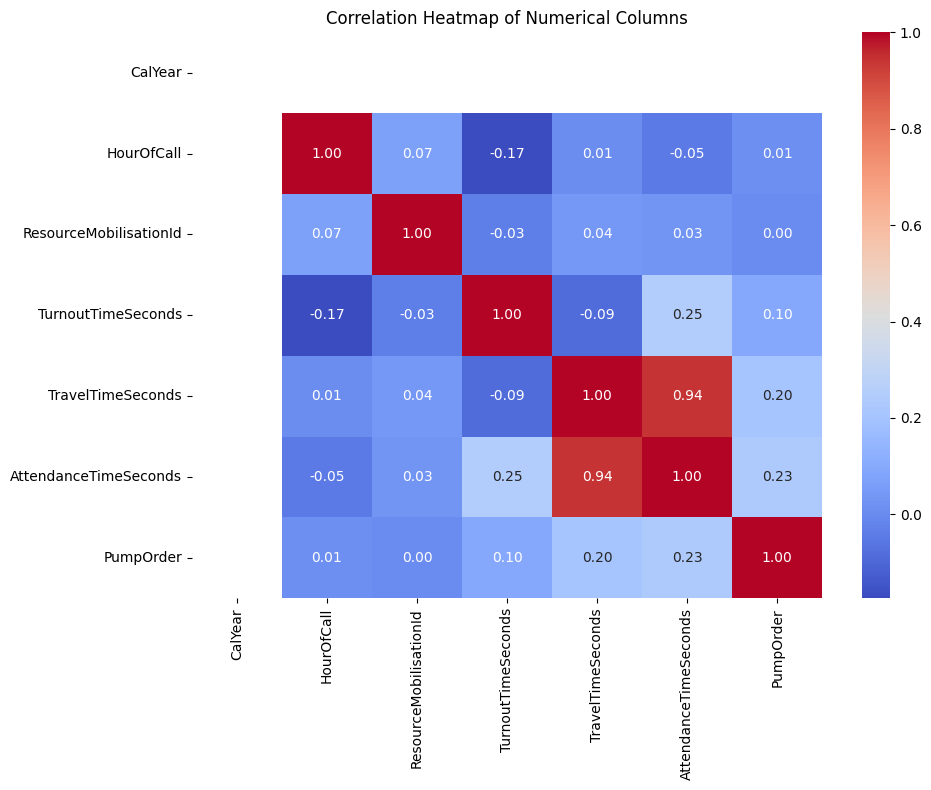

In [40]:
def plot_correlation_heatmap(df: DataFrame):
    # Select numerical columns only
    numerical_cols = [col_name for col_name, col_type in df.dtypes if col_type in ('int', 'double', 'float')]
    if not numerical_cols:
        print("No numerical columns found.")
        return

    # Downsample if necessary to avoid memory issues (optional)
    numerical_df = df.select(numerical_cols).limit(10000)  # limit rows for large datasets

    # Convert to pandas
    pandas_df = numerical_df.toPandas()

    # Compute correlation matrix
    corr = pandas_df.corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of Numerical Columns')
    plt.tight_layout()
    plt.show()


plot_correlation_heatmap(df)

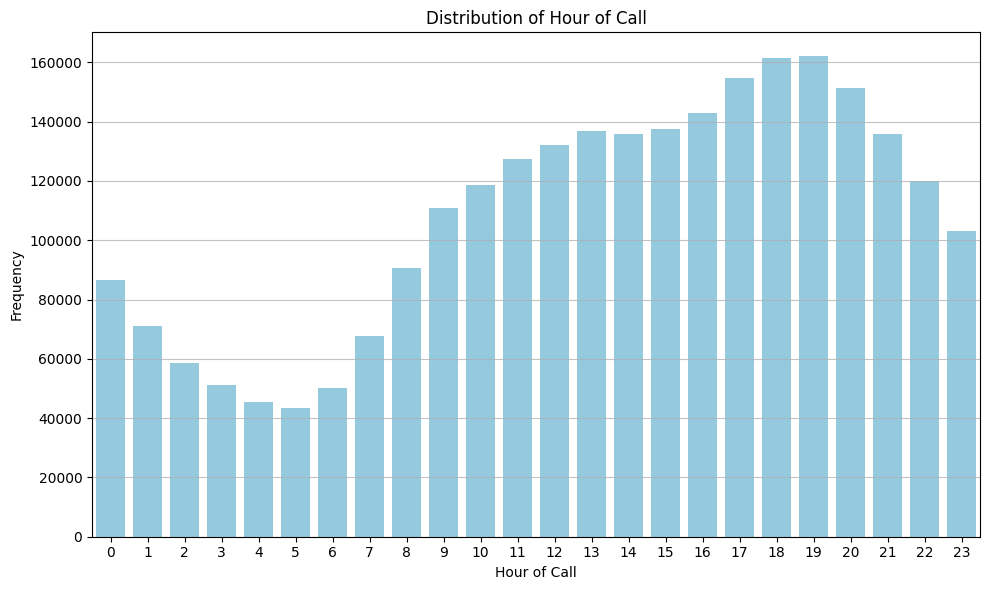

In [41]:
def plot_hour_of_call_histogram(df: DataFrame):
    # Group and count by HourOfCall
    hour_counts_df = (
        df.groupBy("HourOfCall")
          .count()
          .orderBy("HourOfCall")
    )

    # Convert to pandas
    pandas_hour_counts_df = hour_counts_df.toPandas()

    # Plot histogram as bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(data=pandas_hour_counts_df, x="HourOfCall", y="count", color="skyblue")
    plt.title('Distribution of Hour of Call')
    plt.xlabel('Hour of Call')
    plt.ylabel('Frequency')
    plt.xticks(range(0, 24))
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

plot_hour_of_call_histogram(df)

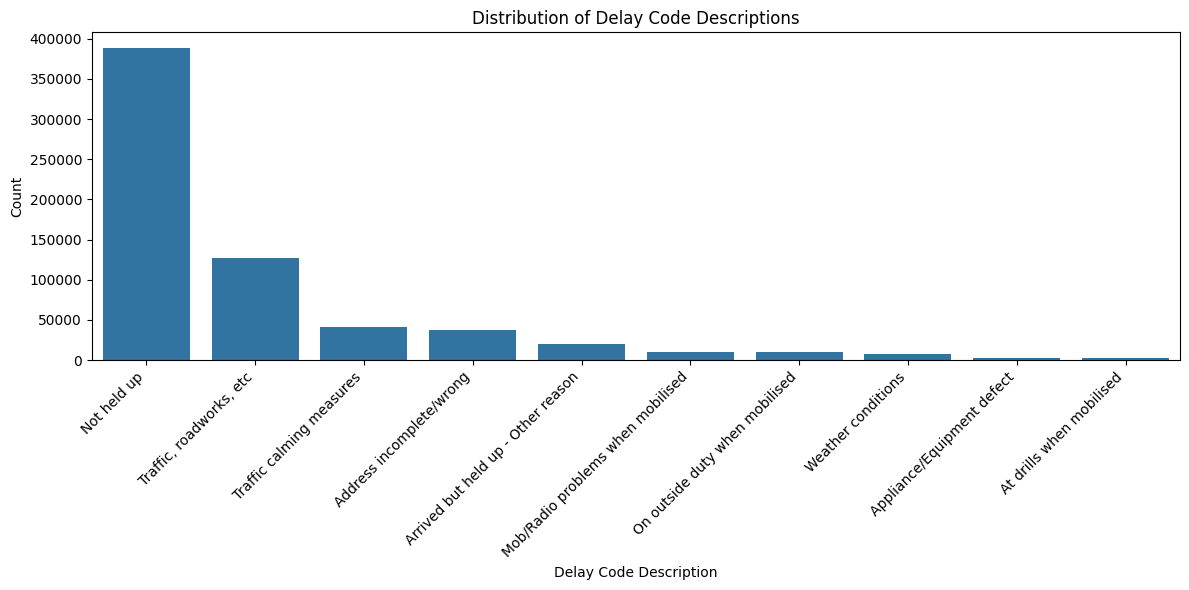

In [42]:
def plot_delay_code_description_histogram(df):
    # Group by DelayCode_Description and count
    delay_counts_df = (
        df.groupBy("DelayCode_Description")
          .count()
          .orderBy("count", ascending=False)  # Optional: sort by frequency
    )

    # Convert to pandas for plotting
    pandas_delay_counts_df = delay_counts_df.toPandas()

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=pandas_delay_counts_df, x="DelayCode_Description", y="count")
    plt.xticks(rotation=45, ha='right')
    plt.title("Distribution of Delay Code Descriptions")
    plt.xlabel("Delay Code Description")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_delay_code_description_histogram(df)

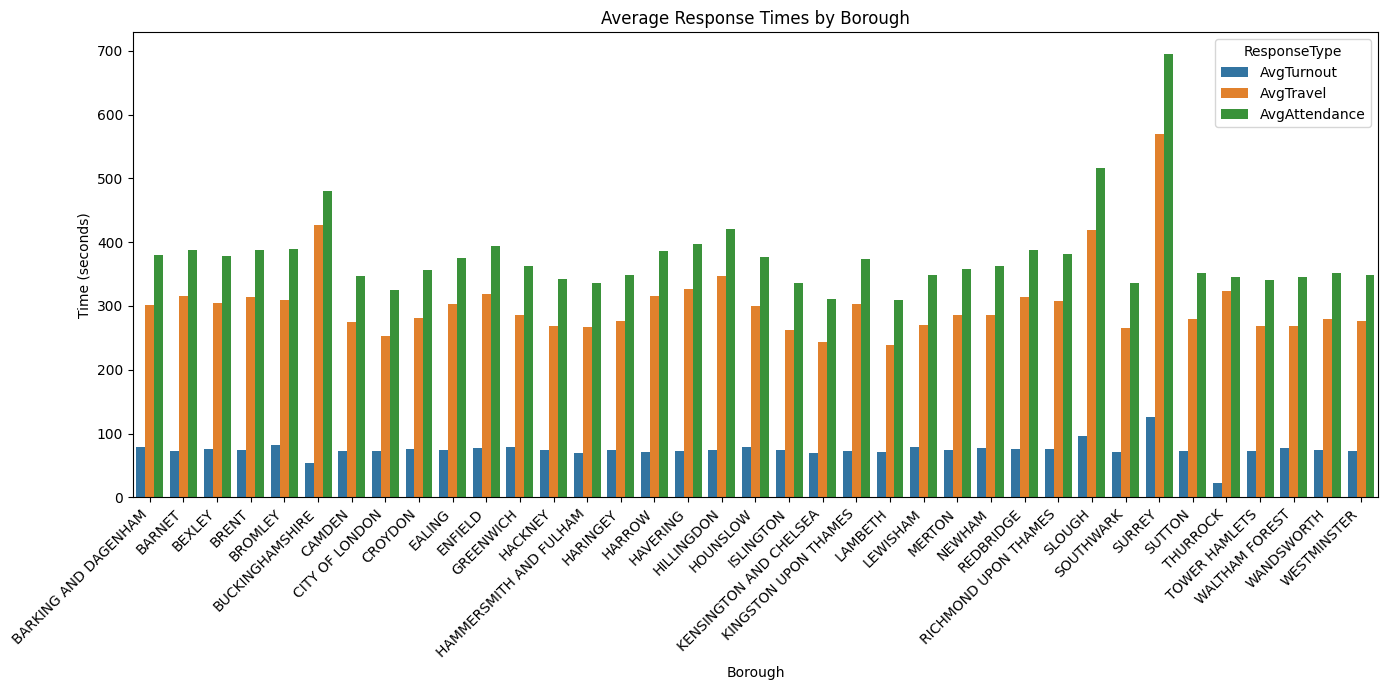

In [47]:
def plot_response_times_by_borough(df):
    """
    Plots average TurnoutTimeSeconds, TravelTimeSeconds, and AttendanceTimeSeconds
    grouped by BoroughName.

    Parameters:
    df (DataFrame): Spark DataFrame containing the necessary columns.
    """
    # Filter out rows with null BoroughName or all time fields null
    filtered_df = df.filter(
        (df.BoroughName.isNotNull()) &
        (
            df.TurnoutTimeSeconds.isNotNull() |
            df.TravelTimeSeconds.isNotNull() |
            df.AttendanceTimeSeconds.isNotNull()
        )
    )

    # Group by BoroughName and calculate average for each time column
    agg_df = filtered_df.groupBy("BoroughName").agg(
        avg("TurnoutTimeSeconds").alias("AvgTurnout"),
        avg("TravelTimeSeconds").alias("AvgTravel"),
        avg("AttendanceTimeSeconds").alias("AvgAttendance")
    )

    # Convert to Pandas for plotting
    pandas_df = agg_df.toPandas().sort_values("BoroughName")

    # Melt for seaborn
    melted_df = pandas_df.melt(id_vars="BoroughName",
                                value_vars=["AvgTurnout", "AvgTravel", "AvgAttendance"],
                                var_name="ResponseType", value_name="Seconds")

    # Plotting
    plt.figure(figsize=(14, 7))
    sns.barplot(data=melted_df, x="BoroughName", y="Seconds", hue="ResponseType")
    plt.xticks(rotation=45, ha="right")
    plt.title("Average Response Times by Borough")
    plt.ylabel("Time (seconds)")
    plt.xlabel("Borough")
    plt.tight_layout()
    plt.show()

plot_response_times_by_borough(df)

/tmp/ipython-input-51-3075775597.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


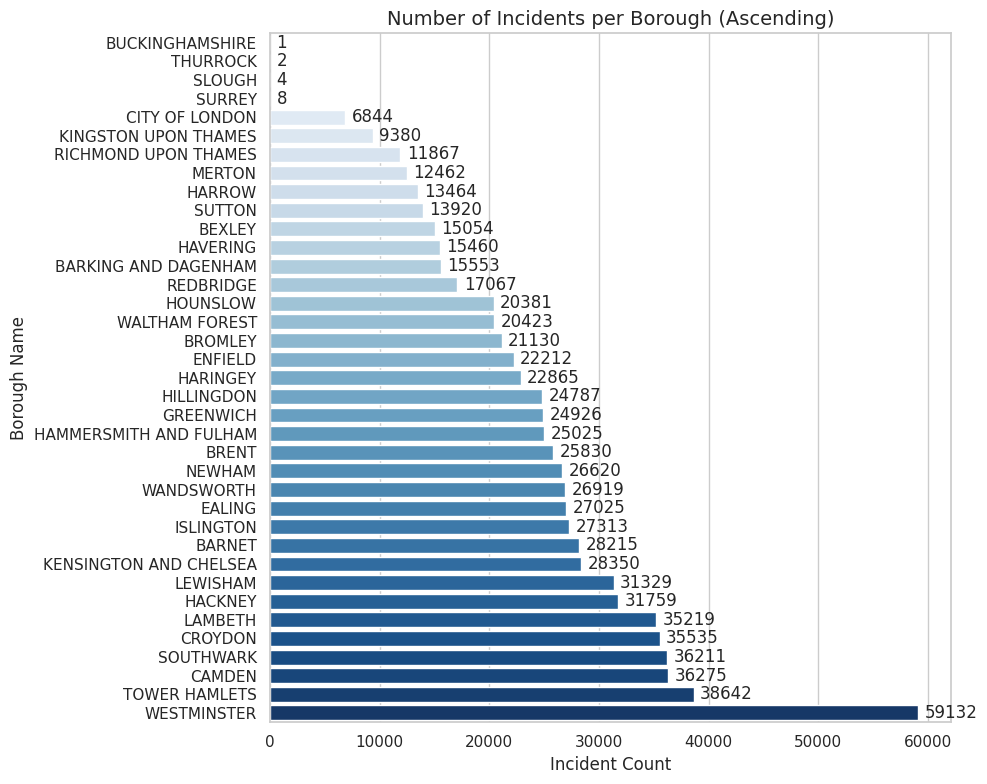

In [51]:
def plot_borough_histogram(df):
    """
    Plots a horizontal histogram of incident counts per BoroughName, sorted ascending,
    with color intensity representing the number of incidents.

    Parameters:
    df (DataFrame): Spark DataFrame with 'BoroughName' column.
    """
    # Group and count using PySpark
    borough_counts = (
        df.filter(col("BoroughName").isNotNull())
          .groupBy("BoroughName")
          .count()
          .orderBy("count")  # ascending
    )

    # Convert to Pandas for plotting
    pandas_df = borough_counts.toPandas()

    # Set style
    plt.figure(figsize=(10, 8))
    sns.set(style="whitegrid")

    # Create horizontal barplot with color intensity
    bar_plot = sns.barplot(
        data=pandas_df,
        y="BoroughName",   # y-axis for horizontal bars
        x="count",         # x-axis is the value
        palette=sns.color_palette("Blues", n_colors=len(pandas_df))
    )

    # Annotate bars
    for i, v in enumerate(pandas_df["count"]):
        bar_plot.text(v + max(pandas_df["count"]) * 0.01, i, str(v), va='center')

    # Titles and labels
    plt.title("Number of Incidents per Borough (Ascending)", fontsize=14)
    plt.xlabel("Incident Count")
    plt.ylabel("Borough Name")
    plt.tight_layout()
    plt.show()

plot_borough_histogram(df)

               BoroughName  IncidentCount  Population  IncidentsPer100k
0                   HARROW          13464    263448.0       5110.685980
1                REDBRIDGE          17067    313392.0       5445.895237
2     KINGSTON UPON THAMES           9380    170454.0       5502.950943
3                 HAVERING          15460    268145.0       5765.537303
4                   MERTON          12462    215219.0       5790.380961
5                   BEXLEY          15054    250853.0       6001.124164
6     RICHMOND UPON THAMES          11867    195513.0       6069.673116
7                  BROMLEY          21130    331162.0       6380.562987
8                   SUTTON          13920    211123.0       6593.312903
9                  ENFIELD          22212    327429.0       6783.760754
10                HOUNSLOW          20381    295706.0       6892.318722
11    BARKING AND DAGENHAM          15553    222308.0       6996.149486
12                  BARNET          28215    395007.0       7142

/tmp/ipython-input-63-1378532562.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, y="BoroughName", x="IncidentsPer100k", palette="mako_r")


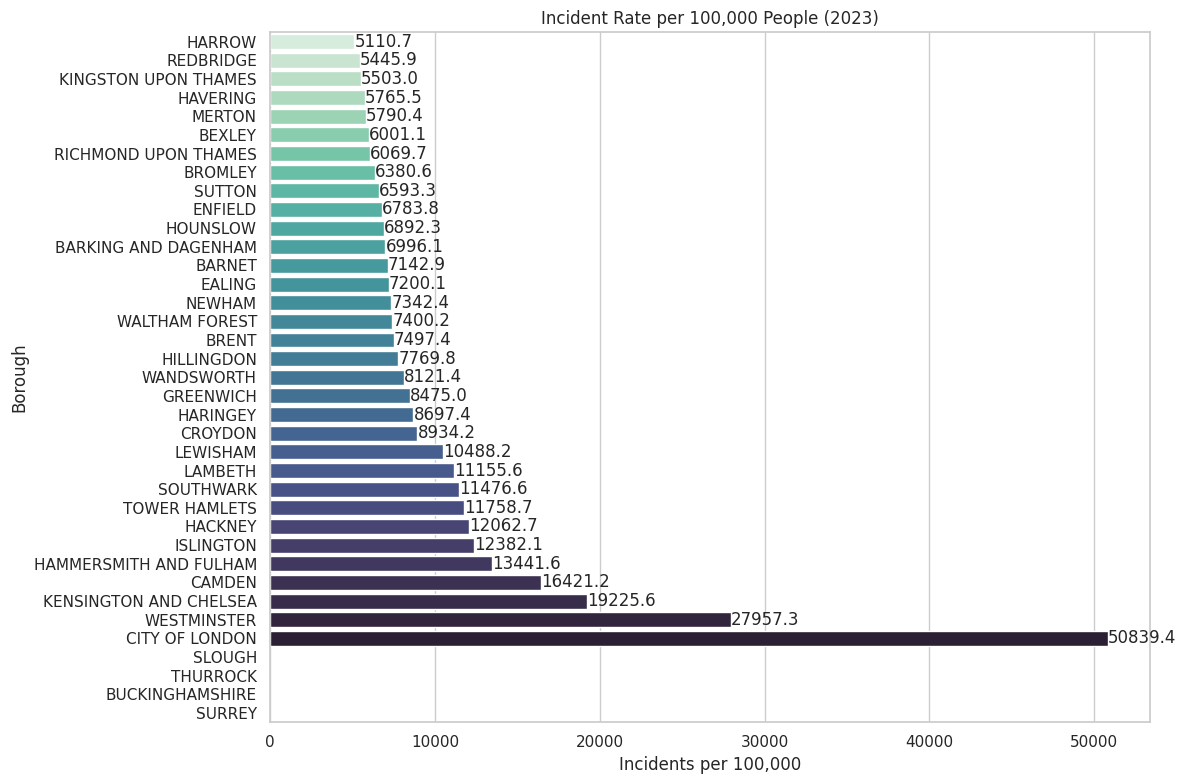

In [63]:
#POPULATION OF EACH BOROUGH ON 2023
population_2023 = [
    {"BoroughName": "BARKING AND DAGENHAM", "Population": 222308},
    {"BoroughName": "BARNET", "Population": 395007},
    {"BoroughName": "BEXLEY", "Population": 250853},
    {"BoroughName": "BRENT", "Population": 344521},
    {"BoroughName": "BROMLEY", "Population": 331162},
    {"BoroughName": "CAMDEN", "Population": 220903},
    {"BoroughName": "CITY OF LONDON", "Population": 13462},
    {"BoroughName": "WESTMINSTER", "Population": 211508},  # Changed from City of Westminster
    {"BoroughName": "CROYDON", "Population": 397741},
    {"BoroughName": "EALING", "Population": 375340},
    {"BoroughName": "ENFIELD", "Population": 327429},
    {"BoroughName": "GREENWICH", "Population": 294113},
    {"BoroughName": "HACKNEY", "Population": 263282},
    {"BoroughName": "HAMMERSMITH AND FULHAM", "Population": 186176},
    {"BoroughName": "HARINGEY", "Population": 262895},
    {"BoroughName": "HARROW", "Population": 263448},
    {"BoroughName": "HAVERING", "Population": 268145},
    {"BoroughName": "HILLINGDON", "Population": 319018},
    {"BoroughName": "HOUNSLOW", "Population": 295706},
    {"BoroughName": "ISLINGTON", "Population": 220584},
    {"BoroughName": "KENSINGTON AND CHELSEA", "Population": 147460},
    {"BoroughName": "KINGSTON UPON THAMES", "Population": 170454},
    {"BoroughName": "LAMBETH", "Population": 315706},
    {"BoroughName": "LEWISHAM", "Population": 298708},
    {"BoroughName": "MERTON", "Population": 215219},
    {"BoroughName": "NEWHAM", "Population": 362552},
    {"BoroughName": "REDBRIDGE", "Population": 313392},
    {"BoroughName": "RICHMOND UPON THAMES", "Population": 195513},
    {"BoroughName": "SOUTHWARK", "Population": 315519},
    {"BoroughName": "SUTTON", "Population": 211123},
    {"BoroughName": "TOWER HAMLETS", "Population": 328626},
    {"BoroughName": "WALTHAM FOREST", "Population": 275980},
    {"BoroughName": "WANDSWORTH", "Population": 331456},
    # Missing boroughs from population data - add with None or 0 as population
    {"BoroughName": "BUCKINGHAMSHIRE", "Population": None},
    {"BoroughName": "SLOUGH", "Population": None},
    {"BoroughName": "SURREY", "Population": None},
    {"BoroughName": "THURROCK", "Population": None}
]
# Convert to Pandas
pop_pd = pd.DataFrame(population_2023)

# Convert to Spark DataFrame
spark = SparkSession.builder.getOrCreate()
pop_spark = spark.createDataFrame(pop_pd)

incident_counts = (
    df.filter(col("BoroughName").isNotNull())
      .groupBy("BoroughName")
      .count()
      .withColumnRenamed("count", "IncidentCount")
)

joined_df = incident_counts.join(pop_spark, on="BoroughName", how="inner")


final_df = joined_df.withColumn(
    "IncidentsPer100k",
    expr("(IncidentCount * 100000.0) / Population")
)

plot_df = final_df.orderBy(col("IncidentsPer100k").asc()).toPandas()
print(plot_df)



plt.figure(figsize=(12, 8))
ax = sns.barplot(data=plot_df, y="BoroughName", x="IncidentsPer100k", palette="mako_r")
plt.title("Incident Rate per 100,000 People (2023)")
plt.xlabel("Incidents per 100,000")
plt.ylabel("Borough")

# Add value labels to the right of each bar
for i, (value) in enumerate(plot_df["IncidentsPer100k"]):
    ax.text(value + 5, i, f"{value:.1f}", va='center')  # +5 shifts the text slightly right of the bar
plt.tight_layout()
plt.show()

In [65]:
df.show()


+--------------+-------+----------+----------------------+-------------+--------------------+--------------------+-----------------+------------------+------------------+-----------------+---------------------+---------------+-------------------+------------------------+------------------------+--------------------+---------+-------------+--------------------+-----------+---------------------+-----------+--------+
|IncidentNumber|CalYear|HourOfCall|ResourceMobilisationId|Resource_Code|PerformanceReporting|DateAndTimeMobilised|DateAndTimeMobile|DateAndTimeArrived|TurnoutTimeSeconds|TravelTimeSeconds|AttendanceTimeSeconds|DateAndTimeLeft|DateAndTimeReturned|DeployedFromStation_Code|DeployedFromStation_Name|DeployedFromLocation|PumpOrder|PlusCode_Code|PlusCode_Description|DelayCodeId|DelayCode_Description|BoroughName|WardName|
+--------------+-------+----------+----------------------+-------------+--------------------+--------------------+-----------------+------------------+-------------